In [ ]:
import pandas as pd
from transformers import BertTokenizer, AdamW, BertModel
import torch.nn as nn
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, cohen_kappa_score
import matplotlib.pyplot as plt
import math
import numpy as np
import warnings
import logging
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
from tqdm import tqdm
from sklearn.metrics import classification_report
import seaborn as sns
logging.disable(logging.WARNING)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
def preprocess_text(text, tokenizer, max_length=512):
    inputs = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=max_length,
        truncation=True,
        padding="max_length",
        return_tensors="pt"
    )
    return inputs

def predict_score(text, model, tokenizer):
    model.eval()  # Set the model to evaluation mode
    inputs = preprocess_text(text, tokenizer)
    inputs.to(device)
    with torch.no_grad():
        outputs = model(**inputs)
        normalized_score = outputs.logits.squeeze().item()  # Extract the score from the output logits

    # Rescale the score from the range [0, 1] to [0, 1000]
    rescaled_score = normalized_score * 1000
    return rescaled_score

def validate(model, val_loader):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    predictions, true_labels = [], []

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            scores = batch['scores'].to(device)  # Make sure your labels are named correctly

            outputs = model(input_ids, attention_mask=attention_mask)
            loss = torch.nn.functional.mse_loss(outputs.squeeze(), scores.squeeze())  # Adjust for your loss function
            total_loss += loss.item()

            predictions.extend(outputs.squeeze().tolist())
            true_labels.extend(scores.tolist())

    avg_loss = total_loss / len(val_loader)
    mse = mean_squared_error(true_labels, predictions)
    return avg_loss, mse

def preprocess_data(row):
    combined_text = row['title_y'] + ' [SEP] ' + row['essay']
    return combined_text

In [ ]:
questoes_df = pd.read_csv('/content/questoes_limpas.csv')
print(len(questoes_df))
questoes_df = questoes_df[questoes_df['Bloco'].notna()]

questoes_df['Bloco'] = questoes_df['Bloco'].replace({
    'CLÍNICA CIRÚRGICA': 'CIRURGIA',
})

print(questoes_df['Bloco'].unique())
print(questoes_df['Bloco'].value_counts())
questoes_df.head()

720
['ÁREA BÁSICA' 'CLÍNICA MÉDICA' 'PEDIATRIA' 'CIRURGIA' 'SAÚDE COLETIVA']
Bloco
CIRURGIA          80
SAÚDE COLETIVA    42
CLÍNICA MÉDICA    41
PEDIATRIA         39
ÁREA BÁSICA       38
Name: count, dtype: int64


,Número,Texto,Bloco,Resposta Correta,Arquivo Prova
480,1,"Paciente do sexo feminino, 22 anos, sem histór...",ÁREA BÁSICA,A,prova_consorcio_sp1_teste_do_progresso_2023.pdf
481,2,A produção de ATP e a disponibilidade de oxigê...,ÁREA BÁSICA,D,prova_consorcio_sp1_teste_do_progresso_2023.pdf
482,3,A integração entre os metabolismos de carboidr...,ÁREA BÁSICA,B,prova_consorcio_sp1_teste_do_progresso_2023.pdf
483,4,Os glóbulos vermelhos são componentes do tecid...,ÁREA BÁSICA,C,prova_consorcio_sp1_teste_do_progresso_2023.pdf
484,5,Em uma angiotomografia observou-se obstrução d...,ÁREA BÁSICA,B,prova_consorcio_sp1_teste_do_progresso_2023.pdf


In [ ]:
class BERTTimbauClassification(nn.Module):
    def __init__(self, num_classes):
        super(BERTTimbauClassification, self).__init__()
        # Load the pre-trained BERT model
        self.bert = BertModel.from_pretrained('neuralmind/bert-base-portuguese-cased')

        # Dropout layer
        self.dropout = nn.Dropout(0.4)

        # A Linear layer to classify into `num_classes`
        self.classifier = nn.Linear(768, num_classes)

    def forward(self, input_ids, attention_mask):
        # Get the output from BERT model
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)

        # Extract the last hidden state of the token `[CLS]` for classification task
        pooled_output = outputs.pooler_output

        # Apply dropout
        pooled_output = self.dropout(pooled_output)

        # Pass through the classifier
        return self.classifier(pooled_output)


num_classes = 6
model = BERTTimbauClassification(num_classes).to(device)
tokenizer = BertTokenizer.from_pretrained('neuralmind/bert-base-portuguese-cased')

In [ ]:
label_encoder = {label: idx for idx, label in enumerate(questoes_df['Bloco'].unique())}
questoes_df['label'] = questoes_df['Bloco'].map(label_encoder)

class TextClassificationDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = str(self.texts[item])
        label = self.labels[item]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            truncation=True,
            return_token_type_ids=True,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Initialize the tokenizer
tokenizer = BertTokenizer.from_pretrained('neuralmind/bert-base-portuguese-cased')

# Create the dataset
max_len = 512
texts = questoes_df['Texto'].values
labels = questoes_df['label'].values

dataset = TextClassificationDataset(
    texts=texts,
    labels=labels,
    tokenizer=tokenizer,
    max_len=max_len
)

# Create a DataLoader
batch_size = 8
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [ ]:
max_len = 512
batch_size = 16
test_size = 0.3

train_data, test_data = train_test_split(questoes_df, test_size=test_size)
val_data, test_data = train_test_split(test_data, test_size=0.5)

train_dataset = TextClassificationDataset(
    texts=train_data['Texto'].tolist(),
    labels=train_data['label'].tolist(),
    tokenizer=tokenizer,
    max_len=max_len
)

val_dataset = TextClassificationDataset(
    texts=val_data['Texto'].tolist(),
    labels=val_data['label'].tolist(),
    tokenizer=tokenizer,
    max_len=max_len
)

test_dataset = TextClassificationDataset(
    texts=test_data['Texto'].tolist(),
    labels=test_data['label'].tolist(),
    tokenizer=tokenizer,
    max_len=max_len
)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
print(f"Train dataset size:{len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")

Train dataset size:168
Test dataset size: 36
Validation dataset size: 36


In [ ]:
EPOCHS = 4
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)
loss_fn = nn.CrossEntropyLoss().to(device)

# Training function
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0

    for d in tqdm(data_loader, desc="Training"):
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        labels = d["labels"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, labels)

        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

# Evaluation function
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in tqdm(data_loader, desc="Evaluating"):
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            labels = d["labels"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, labels)

            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

# Training loop
for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
        model,
        train_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(train_dataset)
    )

    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(
        model,
        val_loader,
        loss_fn,
        device,
        len(test_dataset)
    )

    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/4
----------


Training:   0%|          | 0/11 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Training: 100%|██████████| 11/11 [00:16<00:00,  1.51s/it]


Train loss 1.5527402487668125 accuracy 0.35119047619047616


Evaluating: 100%|██████████| 3/3 [00:01<00:00,  2.46it/s]


Val   loss 1.1176663637161255 accuracy 0.5833333333333333

Epoch 2/4
----------


Training: 100%|██████████| 11/11 [00:16<00:00,  1.49s/it]


Train loss 1.076476882804524 accuracy 0.6726190476190476


Evaluating: 100%|██████████| 3/3 [00:01<00:00,  2.43it/s]


Val   loss 0.7066410183906555 accuracy 0.8055555555555555

Epoch 3/4
----------


Training: 100%|██████████| 11/11 [00:16<00:00,  1.46s/it]


Train loss 0.5914324765855615 accuracy 0.9107142857142857


Evaluating: 100%|██████████| 3/3 [00:01<00:00,  2.50it/s]


Val   loss 0.6206050713857015 accuracy 0.7777777777777777

Epoch 4/4
----------


Training: 100%|██████████| 11/11 [00:15<00:00,  1.45s/it]


Train loss 0.34758780083873053 accuracy 0.9523809523809523


Evaluating: 100%|██████████| 3/3 [00:01<00:00,  2.57it/s]

Val   loss 0.3681946595509847 accuracy 0.9444444444444444



In [ ]:
def get_predictions(model, data_loader):
    model = model.eval()
    texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            texts.extend(d["text"])
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            labels = d["labels"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)

            texts.extend(d["text"])
            predictions.extend(preds)
            prediction_probs.extend(outputs)
            real_values.extend(labels)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    return texts, predictions, prediction_probs, real_values

texts, y_pred, y_pred_probs, y_test = get_predictions(model, val_loader)

print(classification_report(y_test, y_pred, target_names=label_encoder.keys()))

                precision    recall  f1-score   support

   ÁREA BÁSICA       1.00      1.00      1.00         5
CLÍNICA MÉDICA       0.83      1.00      0.91         5
     PEDIATRIA       1.00      0.86      0.92         7
      CIRURGIA       0.93      0.93      0.93        14
SAÚDE COLETIVA       1.00      1.00      1.00         5

      accuracy                           0.94        36
     macro avg       0.95      0.96      0.95        36
  weighted avg       0.95      0.94      0.94        36



In [ ]:
def get_predictions(model, data_loader):
    model = model.eval()
    texts = []
    predictions = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            labels = d["labels"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)

            texts.extend(d["text"])
            predictions.extend(preds.cpu().numpy())
            real_values.extend(labels.cpu().numpy())

    return texts, predictions, real_values

# Get predictions from the model
texts, y_pred, y_test = get_predictions(model, test_loader)

# Convert predictions and true labels to numpy arrays of the same data type
y_pred = np.array(y_pred, dtype=int)
y_test = np.array(y_test, dtype=int)

# Ensure all arrays have the same length
assert len(texts) == len(y_pred) == len(y_test), "Lengths of texts, predictions, and true labels do not match."

# Create a DataFrame for error analysis
df_analysis = pd.DataFrame({
    'text': texts,
    'true_label': y_test,
    'predicted_label': y_pred,
    'correct': y_test == y_pred
})

# Map numerical labels back to original class names
label_decoder = {v: k for k, v in label_encoder.items()}
df_analysis['true_label'] = df_analysis['true_label'].map(label_decoder)
df_analysis['predicted_label'] = df_analysis['predicted_label'].map(label_decoder)

# Filter misclassified samples
misclassified_samples = df_analysis[~df_analysis['correct']]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
misclassified_samples.to_csv('bert_error_analysis.csv', index=False)

In [ ]:
misclassified_samples

,text,true_label,predicted_label,correct
2,"Caminhoneiro, 42 anos, comparece ao serviço de...",CLÍNICA MÉDICA,ÁREA BÁSICA,False
5,"Homem com 60 anos, tabagista de um maço de cig...",CIRURGIA,CLÍNICA MÉDICA,False
13,Uma gestante com 25 semanas realiza o teste de...,CIRURGIA,GINECOLOGIA,False
14,"Gestante, 27 anos, com 12 semanas de gestação,...",CLÍNICA MÉDICA,GINECOLOGIA,False
15,"Uma mãe desesperada procura o médico, porque c...",CLÍNICA MÉDICA,SAÚDE COLETIVA,False
16,Paciente de 60 anos procura ambulatório por qu...,CIRURGIA,CLÍNICA MÉDICA,False
29,"JLS, 28 anos, procura atendimento na Unidade B...",GINECOLOGIA,CIRURGIA,False
30,Você atende na Unidade de Saúde da Família um ...,ÁREA BÁSICA,CLÍNICA MÉDICA,False
34,"Homem, 18 anos, sem comorbidades, procura aten...",CIRURGIA,CLÍNICA MÉDICA,False
36,Observe atentamente a descrição dos sintomas d...,CLÍNICA MÉDICA,SAÚDE COLETIVA,False


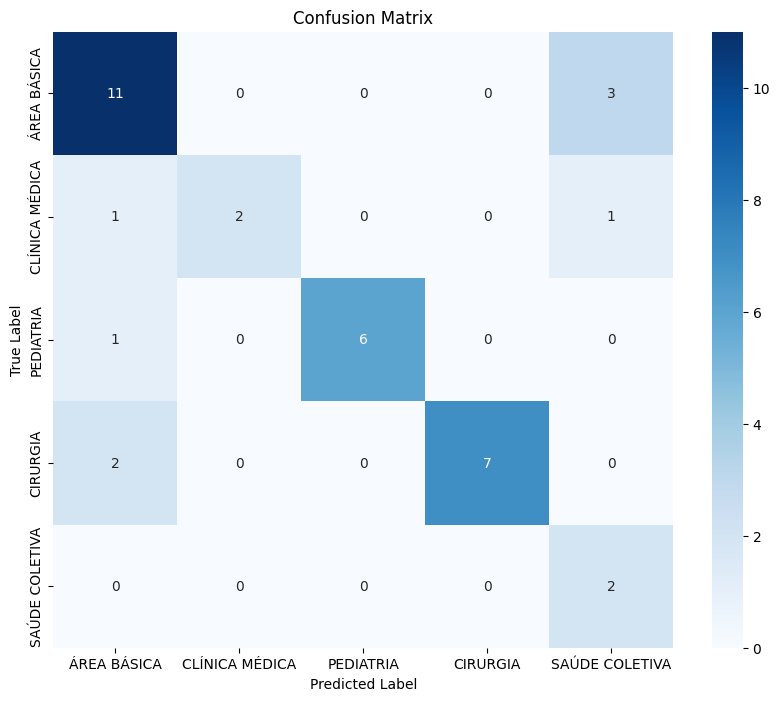

In [ ]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(df_analysis['true_label'], df_analysis['predicted_label'])

# Decode the labels for a readable confusion matrix
labels = [label for label, idx in sorted(label_encoder.items(), key=lambda item: item[1])]

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
torch.save(model, '/content/model.pt')